In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv2
import os

import PIL
import matplotlib.image as image
import seaborn as sns
import pickle 

import tensorflow as tf
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import random
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
img = cv2.imread("./tire_data/testing_data/cracked/Cracked-1.jpg")
img.shape

(748, 748, 3)

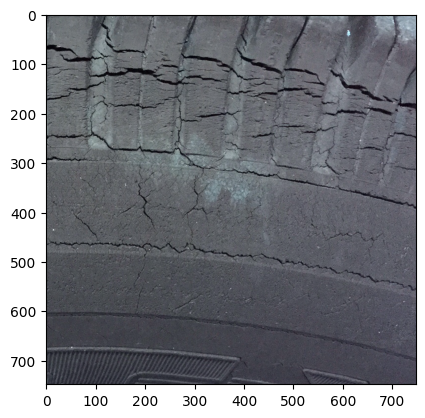

In [4]:
plt.imshow(img)

In [5]:
train_dir = "./tire_data/training_data"
test_dir = "./tire_data/testing_data"

In [6]:
#processing the dataset
train_gen_without_aug = ImageDataGenerator(rescale= 1/255.)                                                       

train_gen_with_aug = ImageDataGenerator(rescale= 1/255.,                                                        
                               rotation_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range = 0.2, 
                               horizontal_flip=True,
                                )

test_gen = ImageDataGenerator(rescale= 1/255.)

In [8]:
train_data = train_gen_with_aug.flow_from_directory(train_dir,
                                            target_size = (224,224), 
                                            class_mode = "categorical",
                                            batch_size = 32
                                            )
test_data = test_gen.flow_from_directory(test_dir,
                                          target_size = (224,224),
                                          class_mode = "categorical",
                                          batch_size = 32
                                          )

Found 703 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [9]:
label_name = list(train_data.class_indices.keys())
label_name

['cracked', 'normal']

In [10]:
image,label = train_data.next()

print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 2)


Metal device set to: Apple M1


2022-11-14 12:33:56.494146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 12:33:56.494247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


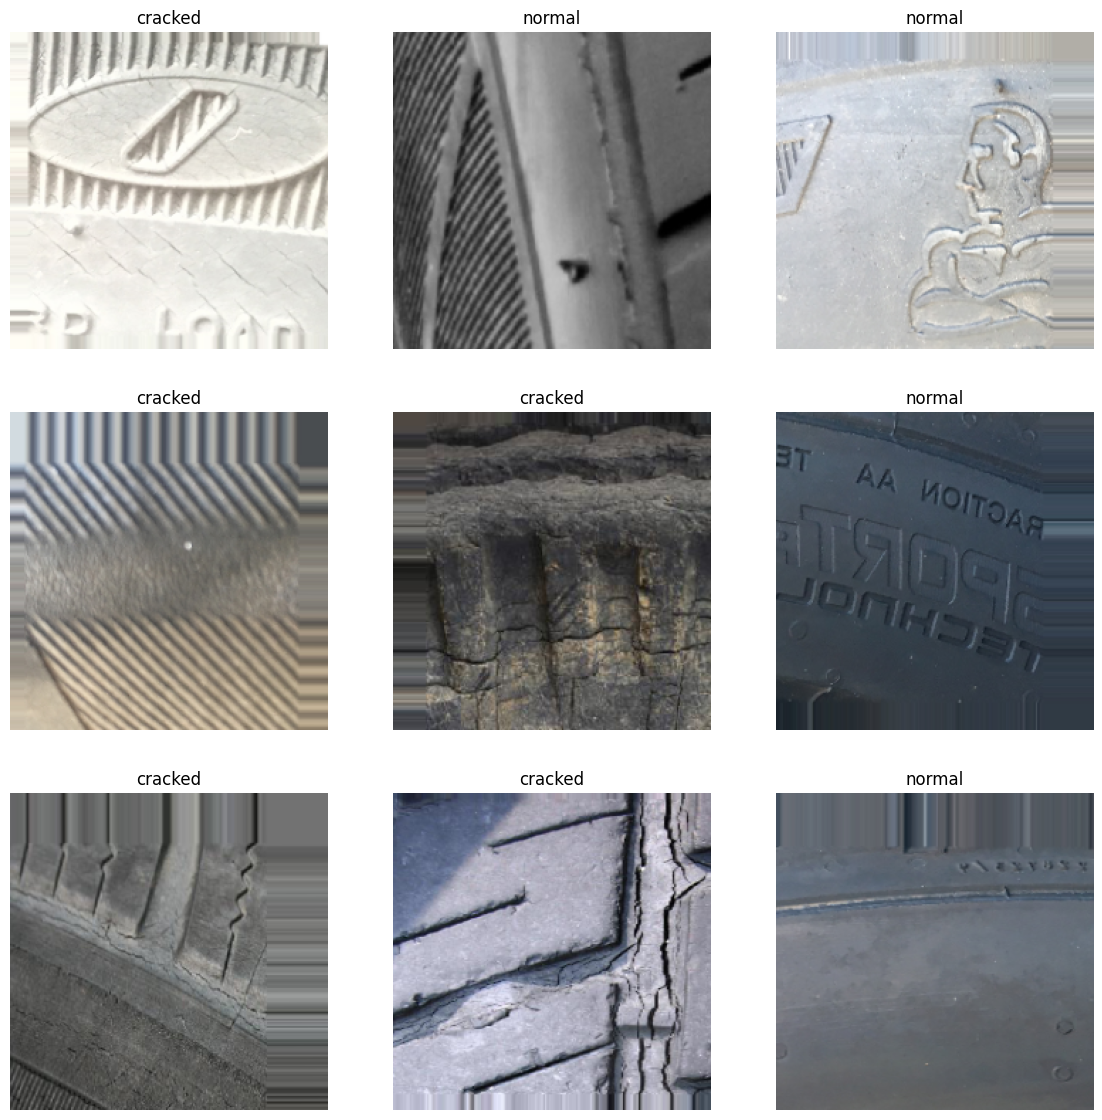

In [11]:
plt.figure(figsize=(14,14))

for i in range(9):
    image,label = train_data.next()

    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(label_name[tf.argmax(label[i])])
    plt.axis("off")

In [12]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50V2(include_top= False,
                                                   input_shape=(224,224, 3),
                                                   pooling='avg',
                                                   weights='imagenet')

In [13]:
for layer in pretrained_model.layers:
    layer.trainable=False


resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

resnet_model.compile(
     loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

resnet_model.fit(
    train_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/10


2022-11-14 12:34:04.304049: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 12:34:05.545233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8464

2022-11-14 12:34:21.915321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 27s 1s/step - loss: 0.3632 - accuracy: 0.8464 - val_loss: 1.0123 - val_accuracy: 0.6954
Epoch 2/10
22/22 [==============================] - 23s 1s/step - loss: 0.1811 - accuracy: 0.9275 - val_loss: 0.7861 - val_accuracy: 0.6985
Epoch 3/10
22/22 [==============================] - 24s 1s/step - loss: 0.1401 - accuracy: 0.9431 - val_loss: 0.6484 - val_accuracy: 0.7508
Epoch 4/10
22/22 [==============================] - 23s 1s/step - loss: 0.1216 - accuracy: 0.9602 - val_loss: 0.6495 - val_accuracy: 0.7692
Epoch 5/10
22/22 [==============================] - 23s 1s/step - loss: 0.1155 - accuracy: 0.9531 - val_loss: 0.4896 - val_accuracy: 0.8154
Epoch 6/10
22/22 [==============================] - 23s 1s/step - loss: 0.0984 - accuracy: 0.9602 - val_loss: 0.8317 - val_accuracy: 0.7538
Epoch 7/10
22/22 [==============================] - 23s 1s/step - loss: 0.1010 - accuracy: 0.9687 - val_loss: 0.7682 - val_accuracy: 0.7600
Epoch 8/10
22/22 [=============

In [14]:
resnet_model.evaluate(train_data)

22/22 [==============================] - 15s 655ms/step - loss: 0.0530 - accuracy: 0.9758


[0.05296487733721733, 0.9758179187774658]

In [15]:
resnet_model_evaluation = resnet_model.evaluate(test_data)

11/11 [==============================] - 9s 748ms/step - loss: 0.9173 - accuracy: 0.7292


In [16]:
print(f"Resnet Model Accuracy: {resnet_model_evaluation[1] * 100: 0.2f} %")

Resnet Model Accuracy:  72.92 %


1/1 [==============================] - 0s 23ms/step


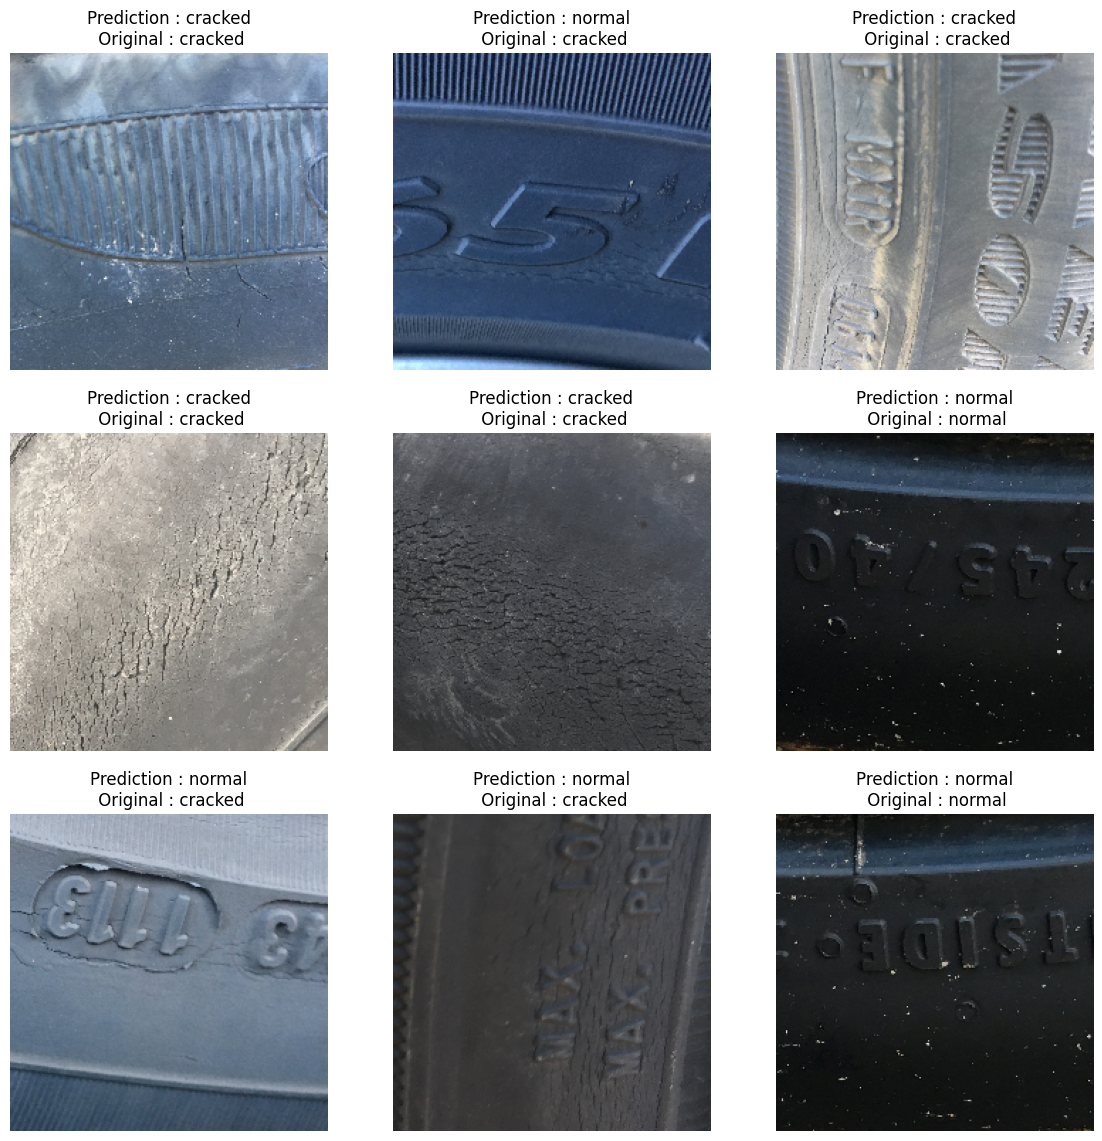

In [18]:
# Resnet model prediction and visualizing

test_label = list(test_data.class_indices.keys())

plt.figure(figsize=(14,14))

for i in range(9):
    image,label = test_data.next()
    resnet_pred = resnet_model.predict(image)
    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(f"Prediction : {test_label[tf.argmax(resnet_pred[i])]}\n Original : {test_label[tf.argmax(label[i])]}")
    plt.axis("off")

- https://www.kaggle.com/datasets/jehanbhathena/tire-texture-image-recognition